In [16]:
import pandas as pd

In [49]:
source_data_path = "./data/SourceData/overall_results.csv"

In [50]:
df = pd.read_csv(source_data_path)

In [51]:
df.head()

,time,territoryFullName,territoryName,territoryKey,totalMandates,availableMandates,numParishes,numParishesApproved,blankVotes,blankVotesPercentage,...,totalVoters,pre.totalMandates,pre.availableMandates,pre.blankVotes,pre.blankVotesPercentage,pre.nullVotes,pre.nullVotesPercentage,pre.votersPercentage,pre.subscribedVoters,pre.totalVoters
0,2019-10-06 18:56:26,Território Nacional,Território Nacional,LOCAL-500000,226.0,0,3092.0,3092.0,112666.0,2.09,...,5380451.0,226.0,0,148118.0,2.67,75298.0,1.36,58.92,9429024.0,5555535.0
1,2019-10-06 18:56:26,Açores,Açores,LOCAL-400000,5.0,0,156.0,156.0,3047.0,3.25,...,93803.0,5.0,0,3250.0,3.60,912.0,1.01,40.65,222247.0,90347.0
2,2019-10-06 18:56:26,Aveiro,Aveiro,LOCAL-010000,16.0,0,147.0,147.0,9163.0,2.49,...,368071.0,16.0,0,11046.0,2.87,4757.0,1.24,59.01,651367.0,384346.0
3,2019-10-06 18:56:26,Beja,Beja,LOCAL-020000,3.0,0,75.0,75.0,1230.0,1.65,...,74485.0,3.0,0,1697.0,2.27,1017.0,1.36,55.17,135739.0,74882.0
4,2019-10-06 18:56:26,Braga,Braga,LOCAL-030000,19.0,0,347.0,347.0,10708.0,2.26,...,474341.0,19.0,0,12825.0,2.64,5270.0,1.09,62.63,775167.0,485460.0


In [52]:
df.describe()

,totalMandates,availableMandates,numParishes,numParishesApproved,blankVotes,blankVotesPercentage,nullVotes,nullVotesPercentage,votersPercentage,subscribedVoters,totalVoters,pre.totalMandates,pre.availableMandates,pre.blankVotes,pre.blankVotesPercentage,pre.nullVotes,pre.nullVotesPercentage,pre.votersPercentage,pre.subscribedVoters,pre.totalVoters
count,1442.000000,1449.000000,1442.000000,1442.000000,1442.000000,1442.00000,1442.000000,1442.000000,1442.000000,1.442000e+03,1.442000e+03,1442.000000,1449.0,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1.442000e+03,1.442000e+03
mean,13.189320,8.374051,295.148405,259.085298,8859.408460,2.50405,6319.765603,1.916949,52.403128,6.580840e+05,3.608977e+05,13.632455,0.0,8669.190707,2.185243,5919.411928,1.698939,54.803044,6.655883e+05,3.797533e+05
std,34.805331,27.279898,632.138577,576.308964,21316.944674,0.77777,15103.138119,0.384052,5.146261,1.593125e+06,8.824765e+05,35.417361,0.0,21536.131141,0.577848,14152.833029,0.390861,5.118124,1.604712e+06,9.244057e+05
min,0.000000,0.000000,54.000000,3.000000,19.000000,0.53000,39.000000,1.280000,35.980000,5.767000e+03,2.833000e+03,0.000000,0.0,32.000000,0.800000,40.000000,1.010000,40.650000,6.383000e+03,3.215000e+03
25%,2.000000,0.000000,75.000000,69.000000,1306.000000,2.13000,1104.000000,1.640000,50.325000,1.304278e+05,6.426900e+04,2.000000,0.0,1230.000000,1.760000,1107.000000,1.470000,51.280000,1.387098e+05,7.448500e+04
50%,4.000000,0.000000,147.000000,133.000000,3061.500000,2.40000,2232.000000,1.810000,53.190000,2.294325e+05,1.173860e+05,5.000000,0.0,2948.000000,2.140000,2141.000000,1.650000,56.310000,2.355580e+05,1.225495e+05
75%,9.000000,6.000000,226.000000,208.000000,6889.000000,2.91000,4343.000000,2.160000,55.960000,3.933140e+05,2.235400e+05,9.000000,0.0,6331.750000,2.520000,3967.000000,1.900000,58.330000,4.025970e+05,2.373320e+05
max,226.000000,226.000000,3092.000000,3092.000000,129599.000000,5.46000,88539.000000,3.350000,60.600000,9.439701e+06,5.380451e+06,226.000000,0.0,148118.000000,3.660000,86473.000000,3.120000,63.220000,9.439701e+06,5.555535e+06


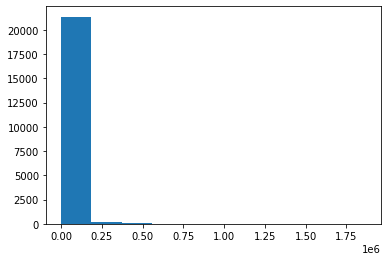

In [48]:
from matplotlib import pyplot
from numpy.random import normal

sample = df.Votes
pyplot.hist(sample, bins=10)
pyplot.show()

In [44]:
from numpy import mean, std

sample_mean = mean(sample)
sample_std = std(sample)
print('Mean=%.3f, Standard Deviation=%.3f' % (sample_mean, sample_std))

Mean=8875.067, Standard Deviation=21484.378


In [45]:
from scipy.stats import norm
dist = norm(sample_mean, sample_std)

In [46]:
values = [value for value in range(30, 70)]
probabilities = [dist.pdf(value) for value in values]

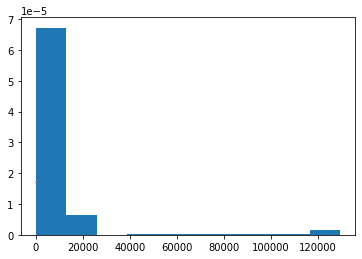

In [47]:
pyplot.hist(sample, bins=10, density=True)
pyplot.plot(values, probabilities)
pyplot.show()

In [37]:
from sklearn.neighbors import KernelDensity

In [38]:
model = KernelDensity(bandwidth=2, kernel='gaussian')
sample = sample.reshape((len(sample), 1))
model.fit(sample)

AttributeError: 'Series' object has no attribute 'reshape'